<a href="https://colab.research.google.com/github/MourineRyabova/portfolio/blob/main/Cohort_analysis_ltv_cac_romi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ метрик продукта

## Оглавление


*   [Цели проекта](#purpose)
*   [Исходные данные](#data)
*   [Предобработка данных](#preprocessing)
*   [Анализ метрик](#metrics)
    *  [Продуктовые метрики](#product)
      * [DAU, WAU, MAU](#dau)
      * [Количество посещений одним пользователем в день](#visits)
      * [Продолжительность пользовательских сессий](#sessions)
      * [Retention Rate для визитов](#rr)
      * [Продуктовый анализ сделанных заказов](#orders)
    *  [Метрики электронной коммерции](#commerce)
      * [Время между просмотром сайта и покупкой](#time)
      * [Среднее количество покупок пользователя за период](#orders_mean)
      * [Расчет среднего чека покупателей](#receipt)
      * [Расчет LTV](#ltv)
    *  [Маркетинговые метрики](#marketing)
      * [Анализ затрат на маркетинг по источникам](#costs)
      * [Расчет окупаемости расходов на маркетинг](#romi)
*  [Выводы (модель поведения среднего пользователя)](#conclusions)
*  [Рекомендации](#recommend)



## Цели проекта <a id="purpose"></a>

Цель проекта - оптимизировать маркетинговый бюджет сервиса "Яндекс-Афиша" методом анализа продуктовых, маркетинговых метрик и метрик электронной коммерции.

Для анализа доступны логи с данными о посещении сервиса и о заказах в период с июня 2017 по конец мая 2018, а также суммы рекламных расходов за это же время.

Рассмотрим доступные нам данные.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
!pip3 install --upgrade --user seaborn
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 292 kB 5.2 MB/s 


In [3]:
costs = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset_project_metrics/costs.csv')
orders = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset_project_metrics/orders_log.csv')
visits = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset_project_metrics/visits_log.csv')
list = [costs, orders, visits]
for i in list:
  i.info()
  display(i.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


В трех файлах содержатся данные о маркетинговых расходах, выручке с заказов покупателей и о длительности сессий при пользовании сервисом. Столбцы с датами имеют формат `object`, его нужно преобразовать в форматы даты для корректной работы.

## Предобработка данных <a id="preprocessing"></a>

In [4]:
#Переводим столбцы в нужный формат
costs['dt'] = costs['dt'].astype('datetime64')
#Попутно меняем названия колонок в соответствии с принятыми нормами
orders.columns = ['buy_ts', 'revenue', 'uid']
orders['buy_ts'] = orders['buy_ts'].astype('datetime64')
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
visits[['end_ts', 'start_ts']] = visits[['end_ts', 'start_ts']].astype('datetime64')


В таблице visits есть дата начала и дата окончания сессии. Во избежание ошибок нужно проверить, что даты корректны (дата окончания сессии больше, чем дата ее начала).

In [5]:
visits['session_time'] = (visits['end_ts'] - visits['start_ts'])
print(visits[visits['session_time'] < '0 days'])


         device              end_ts  ...                   uid      session_time
4181    desktop 2018-03-25 03:18:00  ...  13092152539246794986 -1 days +23:28:00
177972  desktop 2018-03-25 03:09:00  ...   4621202742905035453 -1 days +23:14:00

[2 rows x 6 columns]


In [6]:
#Исключаем некорректные строки из таблицы
visits = visits[visits['session_time'] >= '0 days']
# проверка visits.info()

Файлы с выручкой и расходами проверим на нулевые суммы.

In [7]:
orders.query('revenue == "0"').count()

buy_ts     51
revenue    51
uid        51
dtype: int64

In [8]:
#Удалим пустые строки
orders = orders.query('revenue != "0"')

In [9]:
costs.query('costs == "0"').count()

source_id    0
dt           0
costs        0
dtype: int64

In [10]:
print('Дубликатов в таблице затрат - ', costs.duplicated().sum())
print('Дубликатов в таблице визитов - ', visits.duplicated().sum())
print('Дубликатов в таблице заказов - ', orders.duplicated().sum())

Дубликатов в таблице затрат -  0
Дубликатов в таблице визитов -  0
Дубликатов в таблице заказов -  0


Итак, мы привели данные к нуным типам, проверили отсутствие дубликатов, нулевых и некорректных значений. Можно приступать к анализу.

## Анализ метрик <a id="metrics"></a>

### Анализ продуктовых метрик<a id="product"></a>

**DAU, WAU, MAU** <a id="dau"></a>

Начнем с анализа продуктовых метрик. Посчитаем количество активных пользователей сервиса в среднем за день/неделю/месяц (DAU, WAU, MAU).

In [11]:
#Работаем с таблицей visits. Выделяем в ней столбцы с датой, неделей, месяцем и годом посещения

visits['date'] = visits['start_ts'].dt.date
visits['month'] = visits['start_ts'].astype('datetime64[M]')
visits['week'] = visits['start_ts'].astype('datetime64[W]')

display(visits.head())

,device,end_ts,source_id,start_ts,uid,session_time,date,month,week
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,0 days 00:18:00,2017-12-20,2017-12-01,2017-12-14
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,0 days 00:28:00,2018-02-19,2018-02-01,2018-02-15
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,0 days 00:00:00,2017-07-01,2017-07-01,2017-06-29
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,0 days 00:24:00,2018-05-20,2018-05-01,2018-05-17
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,0 days 00:00:00,2017-12-27,2017-12-01,2017-12-21


In [12]:
#Находим количество уникальных пользователей в день
dau = visits.groupby('date').agg({'uid':'nunique'}).reset_index()
dau_total = dau.mean().astype('int')
print('Количество уникальных пользователей в день (DAU):', dau_total['uid'])
#Находим количество уникальных пользователей в неделю:
wau = visits.groupby('week').agg({'uid':'nunique'}).reset_index()
wau_total = wau.mean().astype('int')
print('Количество уникальных пользователей в неделю (WAU):', wau_total['uid'])
#Находим количество уникальных пользователей в месяц:
mau = visits.groupby('month').agg({'uid':'nunique'}).reset_index()
mau_total = mau.mean().astype('int')
print('Количество уникальных пользователей в месяц (MAU):', mau_total['uid'])

Количество уникальных пользователей в день (DAU): 907
Количество уникальных пользователей в неделю (WAU): 5724
Количество уникальных пользователей в месяц (MAU): 23228


Построим графики для оценки динамики этих показателей.

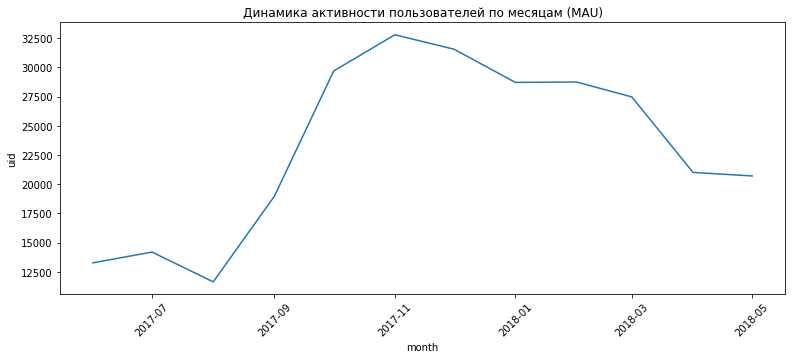

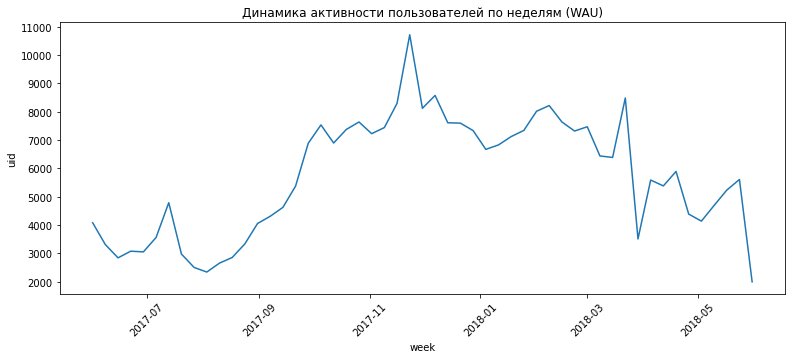

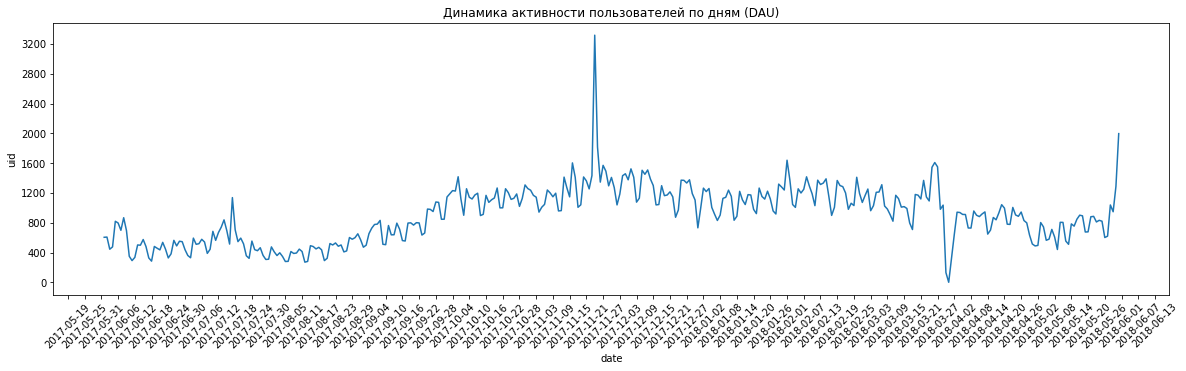

In [13]:
#Выводим график MAU
plt.figure(figsize=(13, 5))
plt.xticks(rotation = 45)
plt.title('Динамика активности пользователей по месяцам (MAU)')
ax = sns.lineplot(data = mau, y = 'uid', x = 'month')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
#Выводим график WAU
plt.figure(figsize=(13, 5))
plt.xticks(rotation = 45)
plt.title('Динамика активности пользователей по неделям (WAU)')
ax = sns.lineplot(data = wau, y = 'uid', x = 'week')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
#Выводим график DAU
plt.figure(figsize=(20, 5))
plt.xticks(rotation = 45)
plt.title('Динамика активности пользователей по дням (DAU)')
ax = sns.lineplot(data = dau, y = 'uid', x = 'date')
ax.xaxis.set_major_locator(plt.MaxNLocator(80))
ax.yaxis.set_major_locator(plt.MaxNLocator(10))


In [14]:
#Посмотрим, как выглядит раскладка посещений по дням недели:
print(dau.sort_values(by = 'date').head(14))

          date  uid
0   2017-06-01  605
1   2017-06-02  608
2   2017-06-03  445
3   2017-06-04  476
4   2017-06-05  820
5   2017-06-06  797
6   2017-06-07  699
7   2017-06-08  868
8   2017-06-09  695
9   2017-06-10  350
10  2017-06-11  292
11  2017-06-12  335
12  2017-06-13  502
13  2017-06-14  499


Обнаруженные тенденции:
*  Все графики показывают локальный всплеск активности пользователей в конце ноября. Дневной график показывает **пик 24-11-2017 - более 3200 пользователей**. Если это успешная рекламная кампания, аналогичный всплеск будет и в данных по заказам на сервисе. 
*  В целом есть тенденция по увеличению числа поисковых запросов в 2018 году (спад после НГ можно считать сезонным), но **в конце марта 2018 виден провал посещаемости**, после которого запросов стало ощутимо меньше. Его причины нужно изучать отдельно. Возможно, это связано с наступлением сезона отпусков.
*  На графике DAU видна цикличная динамика активности: внутри каждой недели есть свои пики и спады. **Локальные пики - четверг и пятница**, когда пользователи выбирают, как провести выходные.

**Количество посещений в день одним пользователем** <a id="visits"></a>

Посмотрим, сколько раз в среднем заходят пользователи на сервис в течение дня.

In [15]:
#Сводная таблица по датам, количеству уникальных пользователей и общему количеству визитов
visits_pivot = visits.pivot_table(index = 'date', values = 'uid', aggfunc = ('nunique', 'count')).reset_index()
#Количество визитов одного пользователя - отношения количества визитов к количеству уникальных пользователей
visits_pivot['n_visits'] = visits_pivot['count'] / visits_pivot['nunique']
print(visits_pivot.head(10))

         date  count  nunique  n_visits
0  2017-06-01    664      605  1.097521
1  2017-06-02    658      608  1.082237
2  2017-06-03    477      445  1.071910
3  2017-06-04    510      476  1.071429
4  2017-06-05    893      820  1.089024
5  2017-06-06    875      797  1.097867
6  2017-06-07    788      699  1.127325
7  2017-06-08    939      868  1.081797
8  2017-06-09    755      695  1.086331
9  2017-06-10    375      350  1.071429


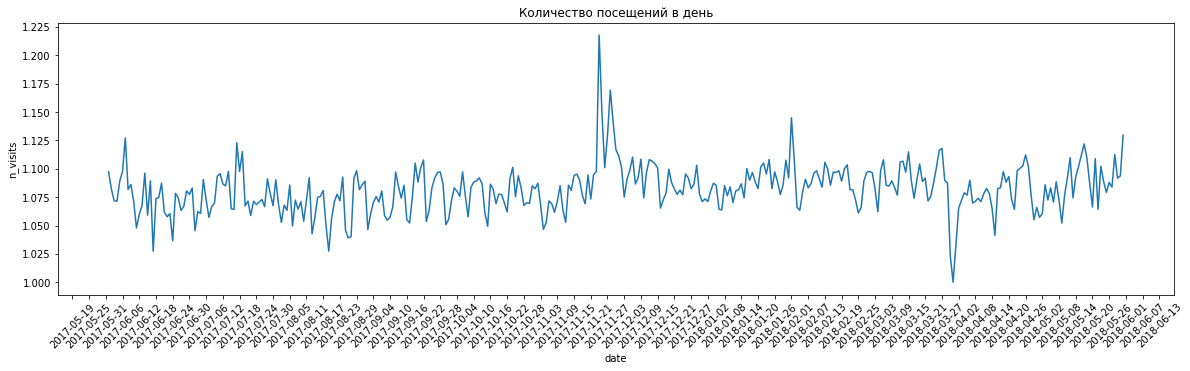

In [16]:
plt.figure(figsize=(20, 5))
plt.xticks(rotation = 45)
plt.title('Количество посещений в день')
ax = sns.lineplot(data = visits_pivot, y = 'n_visits', x = 'date')
ax.xaxis.set_major_locator(plt.MaxNLocator(80))
ax.yaxis.set_major_locator(plt.MaxNLocator(10))

In [17]:
print('Среднее количество посещений на одного пользователя в день - {:.0f}'.format(visits_pivot['count'].sum() / visits_pivot['nunique'].sum()))

Среднее количество посещений на одного пользователя в день - 1


Даже в пиковый период **пользователи ограничиваются в среднем одним визитом в день**. Это может говорить о том, что сервис эргономичен, и цели пользователя выполняются в один приём.

**Продолжительность пользовательских сессий** <a id="sessions"></a>

Теперь нужно определить среднюю длительность этих сессий. Для определения подходящей методики подсчета построим распределение длительности визитов.

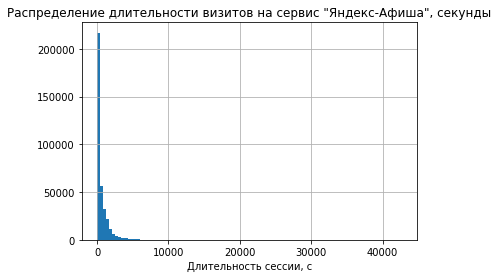

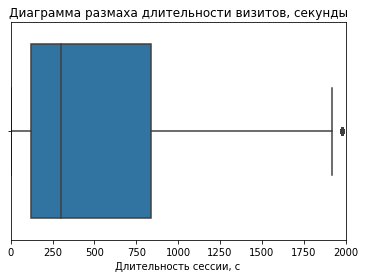

In [18]:
plt.title('Распределение длительности визитов на сервис "Яндекс-Афиша", секунды')
(visits['session_time']/ np.timedelta64(1, 's')).hist(bins = 100)
plt.xlabel('Длительность сессии, с')
plt.show()
plt.title('Диаграмма размаха длительности визитов, секунды')
sns.boxplot(visits['session_time']/ np.timedelta64(1, 's'))
plt.xlabel('Длительность сессии, с')
plt.xlim(0,2000)
plt.show()

In [19]:
(visits['session_time'] / np.timedelta64(1, 'm')).describe()

count    359398.000000
mean         10.717371
std          16.618420
min           0.000000
25%           2.000000
50%           5.000000
75%          14.000000
max         711.000000
Name: session_time, dtype: float64

Распределение по форме не похоже на нормальное. Это экспонента. Для определения среднего значения длительности посещений будем использовать моду.

Дополнительно построенный боксплот показывает, что **75% значений длительности визита укладываются примерно в 2000 секунд**. Значит, на то, чтобы присмотреть себе хороший досуг на выходные, большинство пользователей тратит не более получаса, а 50% - не более 5 минут.

In [20]:
#Находим моду длительности визитов:
visits_mode = ((visits['session_time']/ np.timedelta64(1, 's'))).mode()
print('Наиболее частая длительность посещений сервиса "Яндекс-Афиша" - {:.0f} секунд.'.format(visits_mode[0]))

Наиболее частая длительность посещений сервиса "Яндекс-Афиша" - 60 секунд.


Итак, чаще всего пользовательская сессия на сервисе длится до **60 секунд**. Вряд ли этого времени хватает для оформления заказа. Вероятно, большинство визитов - ознакомительные.

**Retention Rate** <a id="rr"></a>

Посмотрим, сколько пользователей возвращается повторно после первого визита на сервис. Рассчитаем Retention Rate (коэффициент удержания) для пользователей, используя когортный анализ. Интервал для формирования когорт возьмем равным месяцу.

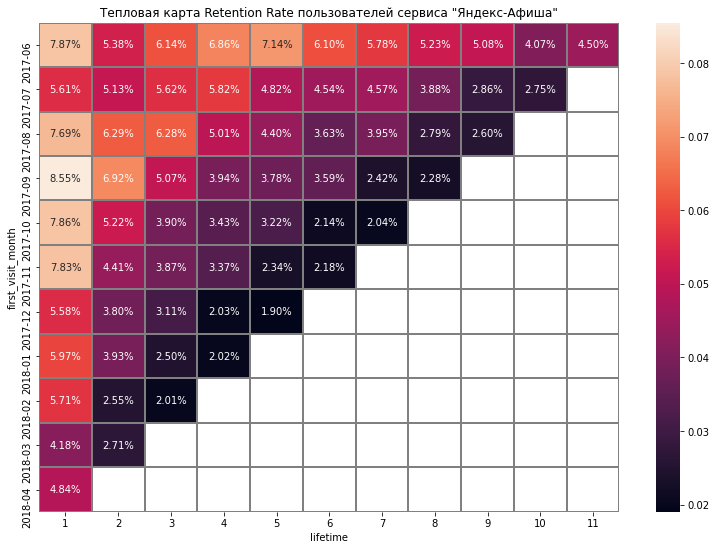

In [21]:
#Находим время первого визита каждого пользователя:
first_visit_ts = visits.groupby('uid')['start_ts'].min()
first_visit_ts.name = 'first_visit_ts'
#Добавляем его в изначальную таблицу:
visits = visits.join(first_visit_ts, on = 'uid')
#Извлекаем из даты только месяц первого визита для формирования когорты:
visits['first_visit_month'] = visits['first_visit_ts'].astype('datetime64[M]')
#Считаем "продолжительность жизни" когорты - время, прошедшее с момента первого обращения к сервису, в месяцах:
visits['lifetime'] = ((visits['month'] - visits['first_visit_month'])/np.timedelta64(1,'M')).round().astype('int')
#Группировка уникальных пользователей по когортам и продолжительности жизни когорты:
cohorts_by_lifetime = visits.groupby(['first_visit_month', 'lifetime']).agg({'uid':'nunique'}).reset_index()
#Считаем количество уникальных пользователей в каждой когорте и добавляем столбец  в группировку по лайфтайм:
first_visits_cohorts = visits.groupby('first_visit_month').agg({'uid':'nunique'}).reset_index()
first_visits_cohorts.columns = ['first_visit_month', 'cohort_users']
cohorts_by_lifetime = cohorts_by_lifetime.merge(first_visits_cohorts, on = 'first_visit_month')
#Рассчитываем коэффициент удержания как отношение количества пользователей, которые вернулись на сервис,
# к общему количеству пользователей в когорте:
cohorts_by_lifetime['retention'] = cohorts_by_lifetime['uid'] / cohorts_by_lifetime['cohort_users']
#Для удобства вывода на экран отформатируем обозначения когорты (оставим только год и месяц):
cohorts_by_lifetime['first_visit_month'] = cohorts_by_lifetime['first_visit_month'].dt.strftime('%Y-%m')
#Сводная таблица зависимости RR от когорты и ее месяца жизни (месяц формирования когорты исключаем):
retention_pivot = (cohorts_by_lifetime.query('lifetime != "0"').
                   pivot_table(index = 'first_visit_month', 
                                columns = 'lifetime', values = 'retention', 
                                aggfunc = 'sum')
)
#Строим тепловую карту RR:
plt.figure(figsize = (13,9))
plt.title('Тепловая карта Retention Rate пользователей сервиса "Яндекс-Афиша"')
sns.heatmap(data = retention_pivot, annot = True, fmt = '.2%', linewidth = 1, linecolor = 'grey')             
plt.show()


In [22]:
print('Средний коэффициент удержания по второму месяцу жизни когорт: {:.2%}.'.format(cohorts_by_lifetime.query('lifetime == "1"')['retention'].mean()))

Средний коэффициент удержания по второму месяцу жизни когорт: 6.52%.


Тепловая карта коэффициента удержания показывает, что **возвращается достаточно небольшой процент пользователей**. Так, на втором месяце жизни когорт этот показатель составляет **в среднем всего 6,5%**. В последующие месяцы он ухудшается.

Виден и **сезонный спад активности ближе к лету**, который мы обнаружили при анализе MAU.

Отдельно можно отметить, что **сентябрьская когорта показала самый высокий RR в октябре**. Возможно, это связано с удачной рекламной кампанией. Проверим это при анализе оформленных заказов.

**Продуктовый анализ сделанных заказов** <a id="orders"></a>

Приступим к анализу заказов пользователей. В первую очередь нас интересуют повторные заказы. Это значит, что нужно выделить пользовательские когорты. За временной интервал примем месяц. 

In [23]:
first_order_time = orders.groupby('uid')['buy_ts'].min()
first_order_time.name = 'first_order_date'
orders = orders.join(first_order_time, on = 'uid')
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
cohorts = orders.groupby('first_order_month').agg({'uid':'nunique'}).reset_index()
cohorts.columns = ['first_order_month', 'cohort_users']
cohorts

,first_order_month,cohort_users
0,2017-06-01,2022
1,2017-07-01,1922
2,2017-08-01,1369
3,2017-09-01,2579
4,2017-10-01,4340
5,2017-11-01,4078
6,2017-12-01,4380
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3534


In [24]:
#Уберем из данных лишнюю строку - пользователя, находящегося за пределами исследуемого интервала.
orders = orders.query('first_order_month != "2018-06-01"')

Разбивка по когортам показывает, что **активнее всего пользователи совершали заказы до декабря 2017 года**. В 2018 году количество новых покупателей падает с каждым месяцем. Рост намечается только в последнем месяце рассматриваемого периода.

Посмотрим на пользовательский `lifetime` и определим, как варьирует средний чек по когортам с течением времени. 

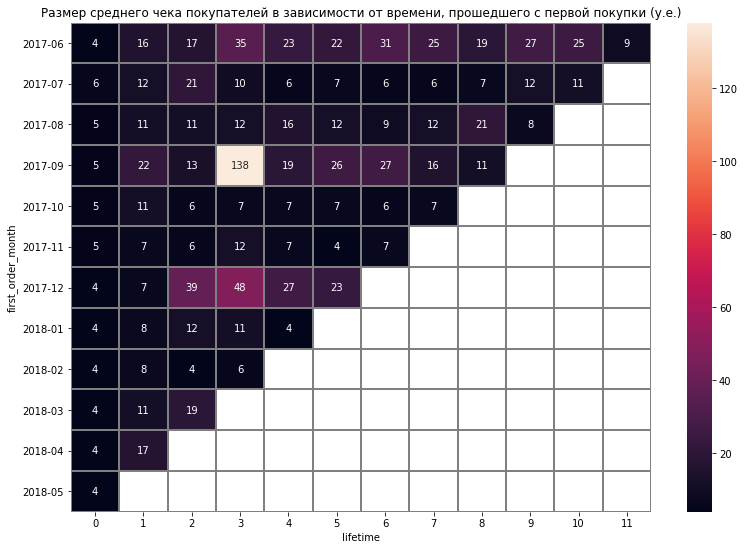

In [25]:
#Группируем данные по когортам, месяцу заказа. Значения - уникальные пользователи и выручка, которую они принесли
cohorts_grouped = orders.groupby(['first_order_month', 'order_month']).agg({'uid':'nunique', 'revenue':'sum'}).reset_index()
#Добавляем столбец "продолжительности жизни" - времени, прошедшего с момента первой покупки:
cohorts_grouped['lifetime'] = ((cohorts_grouped['order_month'] - cohorts_grouped['first_order_month'])/np.timedelta64(1, 'M')).round().astype('int')
#Столбец удельного дохода с пользователя:
cohorts_grouped['revenue_per_user'] = (cohorts_grouped['revenue'] / cohorts_grouped['uid']).astype('int')
#Добавим столбец с количеством пользователей по когортам:
cohorts_grouped = cohorts_grouped.merge(cohorts, on = 'first_order_month')
#Преобразуем столбец когорты в читаемый формат:
cohorts_grouped['first_order_month'] = cohorts_grouped['first_order_month'].dt.strftime('%Y-%m')
#Проверка display('cohorts_grouped').head()
revenue_pivot = cohorts_grouped.pivot_table(index = 'first_order_month', columns = 'lifetime', values = 'revenue_per_user', aggfunc = 'mean')
#Строим тепловую карту зависимости среднего чека от параметра lifetime:
plt.figure(figsize=(13, 9))
plt.title('Размер среднего чека покупателей в зависимости от времени, прошедшего с первой покупки (у.е.)')
sns.heatmap(revenue_pivot, annot = True, linewidth = 1, fmt = '.0f', linecolor='gray')
plt.show()

Сразу бросается в глаза средний чек 138 у.е. на пользователя из когорты 2017-09 в декабре 2017. Проверим, из чего сложилась такая высокая средняя.

In [26]:
orders.query('first_order_month == "2017-09-01" and order_month == "2017-12-01"').sort_values(by = 'revenue', ascending = False).head(10)

,buy_ts,revenue,uid,first_order_date,first_order_month,order_month
23244,2017-12-10 20:17:00,2633.28,5539673724080479777,2017-09-20 19:55:00,2017-09-01,2017-12-01
23165,2017-12-10 13:04:00,1195.64,5539673724080479777,2017-09-20 19:55:00,2017-09-01,2017-12-01
24341,2017-12-15 21:22:00,604.39,5539673724080479777,2017-09-20 19:55:00,2017-09-01,2017-12-01
21961,2017-12-05 00:50:00,402.72,5539673724080479777,2017-09-20 19:55:00,2017-09-01,2017-12-01
22769,2017-12-08 12:25:00,360.55,5539673724080479777,2017-09-20 19:55:00,2017-09-01,2017-12-01
21906,2017-12-04 18:40:00,344.36,5539673724080479777,2017-09-20 19:55:00,2017-09-01,2017-12-01
24775,2017-12-18 19:07:00,337.33,5539673724080479777,2017-09-20 19:55:00,2017-09-01,2017-12-01
25480,2017-12-22 19:43:00,304.94,5539673724080479777,2017-09-20 19:55:00,2017-09-01,2017-12-01
23483,2017-12-11 23:52:00,293.03,5539673724080479777,2017-09-20 19:55:00,2017-09-01,2017-12-01
23196,2017-12-10 15:58:00,243.83,5539673724080479777,2017-09-20 19:55:00,2017-09-01,2017-12-01


Пользователь 5539673724080479777 весь декабрь совершал очень дорогие покупки на сервисе. Посмотрим, как он вел себя в другие периоды.

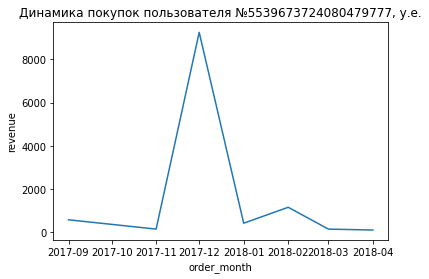

In [27]:
orders_5539673724080479777 = orders.query('uid == "5539673724080479777"')
orders_5539673724080479777_pivot = orders_5539673724080479777.pivot_table(index = 'order_month', values = 'revenue', aggfunc = 'sum').reset_index()
plt.title('Динамика покупок пользователя №5539673724080479777, у.е.')
sns.lineplot(data = orders_5539673724080479777_pivot, y = 'revenue', x = 'order_month')
plt.show()

Такие покупки для этого пользователя - действительно аномалия. На всякий случай можно запросить проверку этих данных.

Тепловая карта показывает, что **самые лояльные клиенты**, которые пользуются сервисом длительное время, **тратят на нем больше всего денег**. Также выделяются когорты пользователей, пришедших в сентябре и декабре. 

> Поскольку тепловая карта среднего чека по когортам показывает не всегда корректные значения, ниже посчитаем этот показатель другим способом и сравним результаты.

Рассчитаем коэффициент удержания, `Retention Rate`, чтобы понять, какая доля пользователей делает повторные покупки.

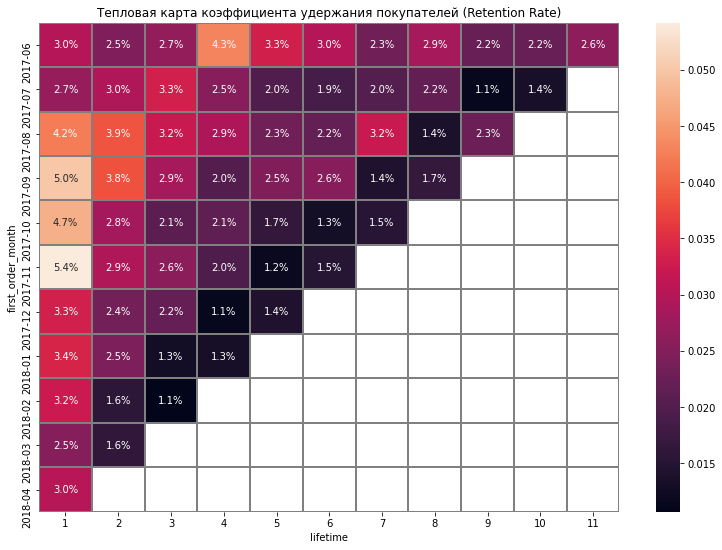

In [28]:
cohorts_grouped['retention'] = cohorts_grouped['uid'] / cohorts_grouped['cohort_users']
cohorts_pivot = cohorts_grouped.query('lifetime != "0"').pivot_table(index = 'first_order_month', columns = 'lifetime', values = 'retention')
plt.figure(figsize=(13,9))
plt.title('Тепловая карта коэффициента удержания покупателей (Retention Rate)')
sns.heatmap(data = cohorts_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray')
plt.show()

In [29]:
print('Средний коэффициент удержания по второму месяцу жизни когорт: {:.2%}.'.format(cohorts_grouped.query('lifetime == "1"')['retention'].mean()))


Средний коэффициент удержания по второму месяцу жизни когорт: 3.70%.


In [30]:
print('Среднее количество новых покупателей в месяц: {:.0f}'.format(orders.groupby('first_order_month').agg({'uid': 'nunique'}).mean()[0]))
print('Общее среднее количество покупателей в месяц: {:.0f}'.format(orders.groupby('order_month').agg({'uid': 'nunique'}).mean()[0]))

Среднее количество новых покупателей в месяц: 3042
Общее среднее количество покупателей в месяц: 3416


Действительно, основную массу покупателей сервиса "Яндекс-Афиши" составляют новые пользователи.

Тепловые карты RR по заказам и по визитам показывают одинаковые тенденции:
*   **Коэффициент удержания невысок**. На второй месяц после регистрации и первого заказа возвращается "просто посмотреть" 6,5% от общего количества пользователей. И в два раза меньше пользователей делает повторный заказ.
*   **Сентябрьская когорта более активна** и по визитам, и по покупкам.
*   К лету 2018 года пользовательская активность (и визиты, и покупки) сезонно сокращаются до минимума.

### Метрики электронной коммерции

**Время между просмотром сайта и покупкой** <a id="time"></a>

Определим средний интервал, который требуется пользователю для принятия решения о первой покупке.

In [31]:
#Группируем пользователей по первой дате визита и первой дате покупки
orders_time = orders.groupby('uid')['buy_ts'].min().reset_index()
visits_time = visits.groupby('uid')['start_ts'].min().reset_index()
#Объединяем полученные группировки в одну таблицу
time_delta = orders_time.merge(visits_time, on = 'uid', how = 'inner')
#Добавляем столбец с временем принятия решения о покупке:
time_delta['time_delta'] = time_delta['buy_ts'] - time_delta['start_ts'] 
display(time_delta.sort_values(by = 'time_delta', ascending = False).head())
time_delta.sort_values(by = 'time_delta', ascending = False).tail()

,uid,buy_ts,start_ts,time_delta
13773,6916757527179896321,2018-05-31 17:35:00,2017-06-02 10:31:00,363 days 07:04:00
31232,15758490655816676033,2018-05-30 11:34:00,2017-06-01 18:47:00,362 days 16:47:00
35066,17701657587540811463,2018-05-31 10:59:00,2017-06-07 17:31:00,357 days 17:28:00
24270,12282157960125853781,2018-05-29 21:51:00,2017-06-06 14:20:00,357 days 07:31:00
8009,4044684955900748187,2018-05-30 13:46:00,2017-06-07 08:23:00,357 days 05:23:00


,uid,buy_ts,start_ts,time_delta
31666,15999808437004191732,2018-01-03 21:35:00,2018-01-03 21:35:00,0 days
13415,6712209320284773443,2018-02-21 22:38:00,2018-02-21 22:38:00,0 days
23623,11937298987876339750,2017-07-14 10:54:00,2017-07-14 10:54:00,0 days
23622,11937291404180323547,2018-02-08 11:13:00,2018-02-08 11:13:00,0 days
12612,6305058841015973283,2018-05-30 11:18:00,2018-05-30 11:18:00,0 days


Самый длительный интервал между первым заходом на сервис и покупкой - около года. Самый короткий - совпадение первого визита и покупки. 

Посмотрим на распределение этого показателя.

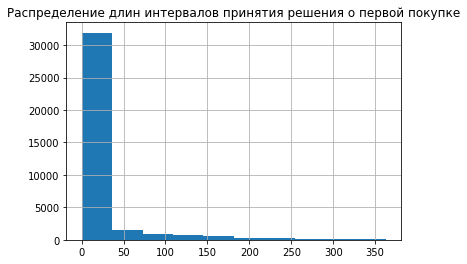

In [32]:
plt.title('Распределение длин интервалов принятия решения о первой покупке')
time_delta['time_delta'] = (time_delta['time_delta']/np.timedelta64(1, 'D')).round().astype('int')
time_delta['time_delta'].hist(bins = 10)
plt.show()

In [33]:
time_delta['time_delta'].describe()

count    36508.000000
mean        16.908376
std         47.098774
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        363.000000
Name: time_delta, dtype: float64

Распределение сильно смещено вправо, поэтому средняя для оценки не подходит. Корректно использовать медиану:

**В 50% случаев решение о покупке принимается пользователем в момент первого визита на сервис**. В 75% этот срок не более двух дней.

**Среднее количество покупок пользователя за период**<a id="orders_mean"></a>

Определим, сколько покупок в среднем совершает один пользователь за полгода.

In [34]:
#Готовим таблицу для анализа: формируем столбец "время жизни" когорты: 
orders['lifetime'] = ((orders['order_month'] - orders['first_order_month'])/np.timedelta64(1,'M')).round().astype('int')
#Группируем по когорте и времени ее жизни количество заказов:
orders_grouped = orders.groupby(['first_order_month', 'lifetime']).agg({'revenue':'count'}).reset_index()
#Добавляем количество пользователей в каждой когорте
orders_grouped = orders_grouped.merge(cohorts, on = 'first_order_month')
#Переименовываем столбцы
orders_grouped.columns = ['cohort', 'lifetime', 'n_orders', 'cohort_users']

#Находим среднее количество покупок на пользователя
orders_grouped['order_per_user'] = orders_grouped['n_orders'] / orders_grouped['cohort_users']
display(orders_grouped.head())
print('Количество заказов за период 06.2017 - 05.2018:', orders_grouped['n_orders'].sum())
print('Количество пользователей за период 06.2017 - 05.2018:', cohorts['cohort_users'].sum())
print('Средневзвешенное количество заказов на пользователя за период 06.2017 - 05.2018: {:.2f}'.format(orders_grouped['n_orders'].sum()/cohorts['cohort_users'].sum()))

,cohort,lifetime,n_orders,cohort_users,order_per_user
0,2017-06-01,0,2353,2022,1.163699
1,2017-06-01,1,177,2022,0.087537
2,2017-06-01,2,171,2022,0.084570
3,2017-06-01,3,224,2022,0.110781
4,2017-06-01,4,291,2022,0.143917


Количество заказов за период 06.2017 - 05.2018: 50363
Количество пользователей за период 06.2017 - 05.2018: 36509
Средневзвешенное количество заказов на пользователя за период 06.2017 - 05.2018: 1.38


In [35]:
#Строим сводную таблицу по среднему количеству покупок:
orders_pivot = orders_grouped.pivot_table(index = 'cohort', columns = 'lifetime', values = 'order_per_user', aggfunc = 'mean')
orders_pivot = orders_pivot.cumsum(axis=1).round(2)
print('Сводная таблица среднего количества покупок на человека по когортам нарастающим итогом:')
display(orders_pivot.fillna(''))
#Важно: это не средневзвешенная, и ее нельзя использовать, если размеры когорт сильно разнятся
print('Среднее количество покупок на пользователя за полгода: {:.2f}'.format((orders_pivot.mean(axis = 0)[5])))

Сводная таблица среднего количества покупок на человека по когортам нарастающим итогом:


lifetime,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-06-01,1.16,1.25,1.34,1.45,1.59,1.7,1.83,1.92,2.03,2.1,2.15,2.19
2017-07-01,1.14,1.19,1.25,1.31,1.34,1.39,1.42,1.44,1.47,1.49,1.51,
2017-08-01,1.12,1.2,1.27,1.33,1.39,1.44,1.47,1.53,1.56,1.6,,
2017-09-01,1.14,1.22,1.28,1.35,1.37,1.41,1.46,1.48,1.5,,,
2017-10-01,1.14,1.22,1.25,1.28,1.31,1.34,1.35,1.38,,,,
2017-11-01,1.18,1.27,1.32,1.37,1.4,1.42,1.44,,,,,
2017-12-01,1.15,1.21,1.26,1.3,1.32,1.34,,,,,,
2018-01-01,1.12,1.19,1.24,1.25,1.28,,,,,,,
2018-02-01,1.12,1.18,1.2,1.22,,,,,,,,


Среднее количество покупок на пользователя за полгода: 1.43


В среднем за полгода пользователи из нашей выборки делают по одному заказу. За год, судя по результату первой когорты, в среднем накопится 2 заказа на покупателя.

**Расчет среднего чека покупателей**<a id="receipt"></a>

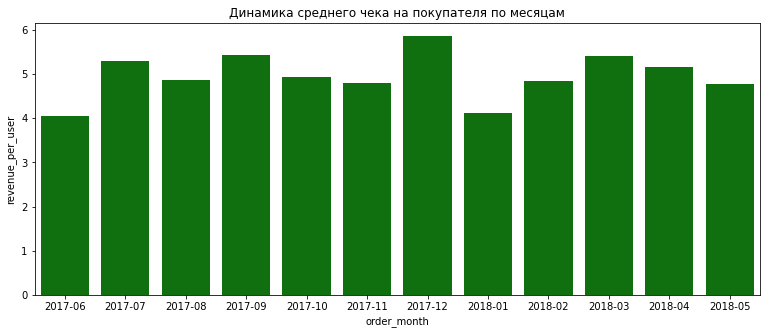

In [36]:
revenue_per_user = orders.groupby('order_month').agg({'revenue':'sum', 'uid':'count'}).reset_index()
revenue_per_user.columns = ['order_month', 'total_revenue', 'n_orders']
revenue_per_user['revenue_per_user'] = revenue_per_user['total_revenue'] / revenue_per_user['n_orders']
revenue_per_user['order_month'] = revenue_per_user['order_month'].dt.strftime('%Y-%m')
plt.figure(figsize = (13,5))
plt.title('Динамика среднего чека на покупателя по месяцам')
ax = sns.barplot(data = revenue_per_user, x = 'order_month', y = 'revenue_per_user', color = 'green')
#ax.tick_params(axis='x', rotation=45)
plt.show()

In [37]:
print('Максимальный доход на пользователя - {:.2f} у.е.'.format(revenue_per_user['revenue_per_user'].max()))

Максимальный доход на пользователя - 5.86 у.е.


In [38]:
print('Минимальный доход на пользователя - {:.2f} у.е.'.format(revenue_per_user['revenue_per_user'].min()))

Минимальный доход на пользователя - 4.06 у.е.


In [39]:
print('Средний чек по всей выборке: {:.2f} у.е.'.format(revenue_per_user['total_revenue'].sum()/revenue_per_user['n_orders'].sum()))

Средний чек по всей выборке: 5.00 у.е.


Максимальный доход на пользователя - 5.86 у.е. - достигнут в декабре 2017 года, а минимальный (4.06 у.е.) - в следующем за ним месяце.

В целом за рассматриваемый период по всем пользователям **средний чек - 5 у.е.**

Ранее мы строили тепловую карту динамики среднего чека по когортам и обнаружили аномалию (очень дорогие заказы одного пользователя) именно в декабре. Эта аномалия поднимает средний чек и в текущей группировке.

**Расчет LTV (прибыли, полученной от клиента за все время пользования сервисом)** <a id="ltv"></a>

Для начала сравним динамику затрат сервиса "Яндекс-Афиша" с динамикой доходов по месяцам.

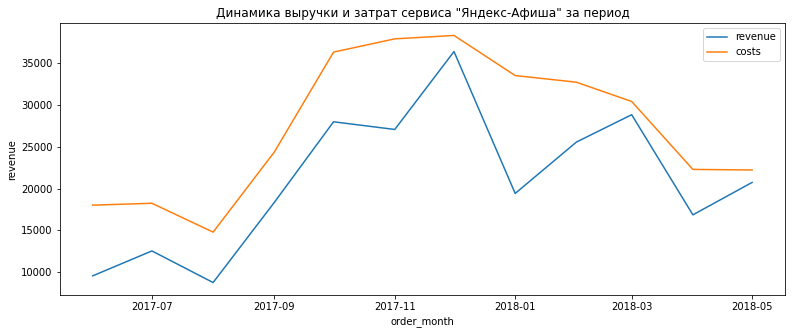

In [40]:
costs['cost_month'] = costs['dt'].astype('datetime64[M]')
costs_grouped_by_month = costs.groupby('cost_month').agg({'costs':'sum'}).reset_index()
orders_grouped_by_month = orders.groupby('order_month').agg({'revenue':'sum'}).reset_index()
orders_and_costs = orders_grouped_by_month.merge(costs_grouped_by_month, left_on = 'order_month', right_on = 'cost_month')
orders_and_costs = orders_and_costs.drop(columns = 'cost_month')
plt.figure(figsize = (13,5))
plt.title('Динамика выручки и затрат сервиса "Яндекс-Афиша" за период')
sns.lineplot(data = orders_and_costs, x = 'order_month', y = 'revenue')
sns.lineplot(data = orders_and_costs, x = 'order_month', y = 'costs')
plt.legend(labels=['revenue','costs'], facecolor='white')
plt.show()


В выбранный период затраты стабильно превышают выручку. Показатель LTV покажет, за какой период ситуация может измениться.

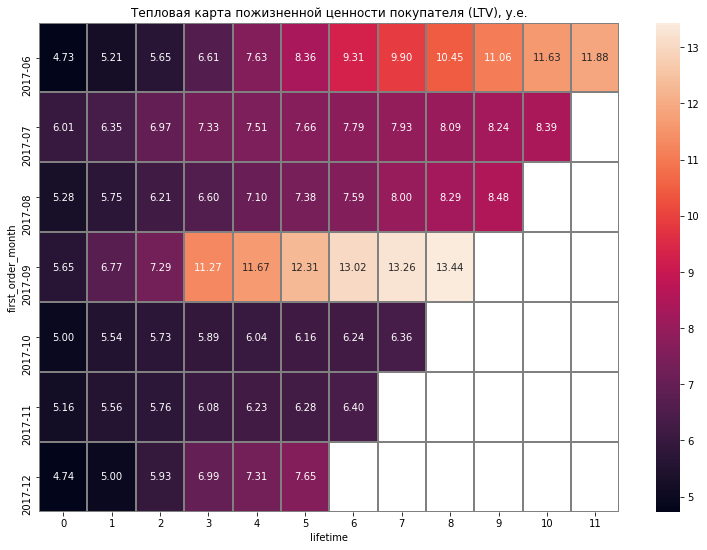

In [41]:
cohort_revenue_by_month = orders.groupby(['first_order_month', 'order_month']).agg({'revenue':'sum'}).reset_index()
cohort_revenue_by_month = cohort_revenue_by_month.merge(cohorts, on = 'first_order_month')
cohort_revenue_by_month['lifetime'] = ((cohort_revenue_by_month['order_month'] - cohort_revenue_by_month['first_order_month']) / np.timedelta64(1,'M')).round().astype('int')
marg = 1
cohort_revenue_by_month['gross_profit'] = cohort_revenue_by_month['revenue'] * marg
cohort_revenue_by_month['ltv'] = cohort_revenue_by_month['gross_profit'] / cohort_revenue_by_month['cohort_users']
old_cohorts = ['2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12']
cohort_revenue_by_month['first_order_month'] = cohort_revenue_by_month['first_order_month'].dt.strftime('%Y-%m')
ltv_pivot = cohort_revenue_by_month.query('first_order_month in @old_cohorts').pivot_table(index = 'first_order_month', columns = 'lifetime', values = 'ltv', aggfunc = 'sum')
cum_ltv = ltv_pivot.cumsum(axis=1).round(2)
plt.figure(figsize=(13,9))
plt.title('Тепловая карта пожизненной ценности покупателя (LTV), у.е.')
sns.heatmap(data = cum_ltv, annot = True, fmt = '.2f', linewidth = 1, linecolor = 'grey') 
plt.show()

Тепловая карта LTV показывает ту же закономерность: **самые интересные для бизнеса когорты - июньская и сентябрьская**. Виден и скачок LTV когорты 2017-09 в декабре, когда среднюю выручку (и валовую прибыль, соответственно) подняли аномально крупные заказы одного пользователя.

In [42]:
print('Средняя LTV по когортам за 6 месяцев - {:.2f} у.е.'.format(cum_ltv.mean(axis = 0)[5]))

Средняя LTV по когортам за 6 месяцев - 7.97 у.е.


### Маркетинговые метрики <a id="marketing"></a>

**Анализ затрат на маркетинг по источникам** <a id="costs"></a>

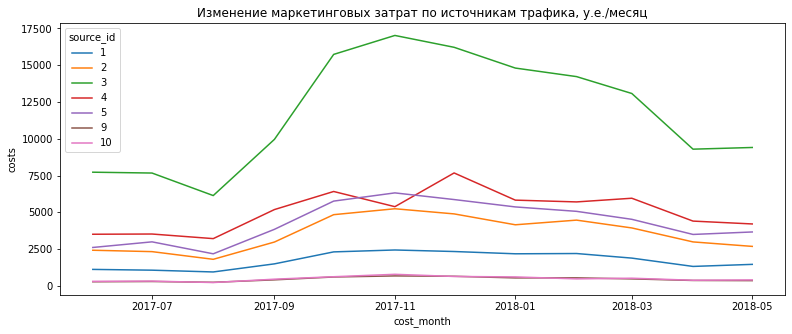

In [43]:
monthly_costs_by_source = costs.groupby(['cost_month','source_id']).agg({'costs':'sum'}).reset_index()
plt.figure(figsize = (13,5))
plt.title('Изменение маркетинговых затрат по источникам трафика, у.е./месяц')
sns.lineplot(data = monthly_costs_by_source, x = 'cost_month', y = 'costs', hue = 'source_id', palette = 'tab10')
plt.show()

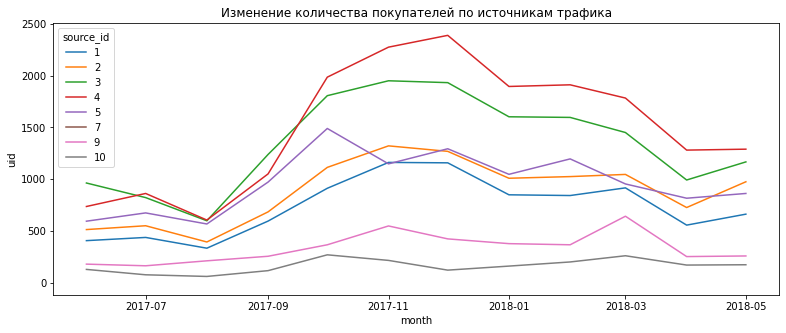

In [44]:
visits.head()
#Фильтруем из посетителей только покупателей и группируем по ежемесячному количеству в зависимости от источника
monthly_visits_by_source = visits.query('uid in @orders.uid').groupby(['month','source_id']).agg({'uid':'nunique'}).reset_index()
plt.figure(figsize = (13,5))
plt.title('Изменение количества покупателей по источникам трафика')
sns.lineplot(data = monthly_visits_by_source, x = 'month', y = 'uid', hue = 'source_id', palette = 'tab10')
plt.show()

Самым потенциально выгодным источником трафика выглядит №4 - количество покупателей из него максимальное, а затраты не самые высокие. Проверим эту гипотезу, рассчитав CAC (стоимость привлечения клиента).

In [45]:
#Группируем затраты по источникам трафика
costs_by_source = costs.groupby('source_id').agg({'costs':'sum'})
#Группируем пользователей по источникам трафика
users_by_source = visits.sort_values(by = ['uid','start_ts']).groupby('uid').agg({'source_id' : 'first'}).reset_index()
#Фильтруем из общего числа пользователей только покупателей
buyers_by_source = users_by_source.query('uid in @orders.uid').groupby('source_id').agg({'uid':'nunique'})
print('Разбивка покупателей по источнику трафика:')
buyers_by_source

Разбивка покупателей по источнику трафика:


,uid
source_id,
1,2896
2,3503
3,10467
4,10295
5,6931
7,1
9,1088
10,1327


In [46]:
print('Разбивка затрат по источнику трафика:')
display(costs_by_source)

Разбивка затрат по источнику трафика:


,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


In [47]:
#Удаляем строку с единичным источником трафика
buyers_by_source = buyers_by_source.query('source_id != "7"')
#Объединяем таблицы с расходами по источникам с покупателями по источникам
cac = costs_by_source.join(buyers_by_source).reset_index().rename(columns = {'uid':'buyers'})
#Рассчитываем CAC (расходы на привлечение одного клиента)
cac['cac'] = cac['costs'] / cac['buyers']

cac

,source_id,costs,buyers,cac
0,1,20833.27,2896,7.193809
1,2,42806.04,3503,12.219823
2,3,141321.63,10467,13.501637
3,4,61073.60,10295,5.932356
4,5,51757.10,6931,7.467479
5,9,5517.49,1088,5.071222
6,10,5822.49,1327,4.387709


In [48]:
cac_mean = cac['costs'].sum() / cac['buyers'].sum()
print('Средняя стоимость привлечения клиента - {:.2f} у.е.'.format(cac_mean))

Средняя стоимость привлечения клиента - 9.02 у.е.


Итак, **самая высокая стоимость привлечения клиента - в источнике №3**. Это было видно и на графике. А **источник №4 - наиболее перспективный**. Даёт макисмальное количество покупателей при средней стоимости привлечения.


Для наглядности покажем то же самое на графике.

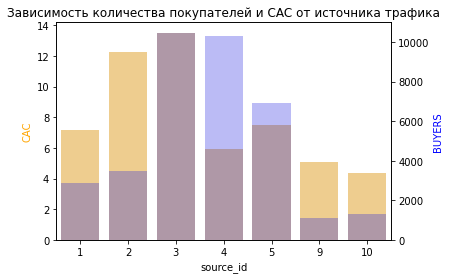

In [49]:
plt.title('Зависимость количества покупателей и CAC от источника трафика')
ax = sns.barplot(data = cac, x = 'source_id', y = 'cac', color = 'orange', alpha = 0.5)
ax2 = plt.twinx()
ax2 = sns.barplot(data = cac, x = 'source_id', y = 'buyers', color = 'blue', alpha = 0.3, ax = ax2)
ax.set_ylabel('CAC', color='orange')
ax2.set_ylabel('BUYERS', color='blue')

plt.show()

На графике видно, что источник №5 тоже может быть потенциально интересным для развития, хотя его CAC выше, чем у №4.

**Расчет окупаемости расходов на маркетинг (ROMI)** <a id="romi"></a>

Если сравнить средний САС с посчитанными нами ранее LTV, получим, что за рассматриваемый период затраты на привлечение окупились только для первой (июньской) и для сентябрьской когорт.

Проверим, как по когортам окупаются маркетинговые затраты в зависимости от источника трафика. Рассчитаем ROMI (отношение LTV к CAC).

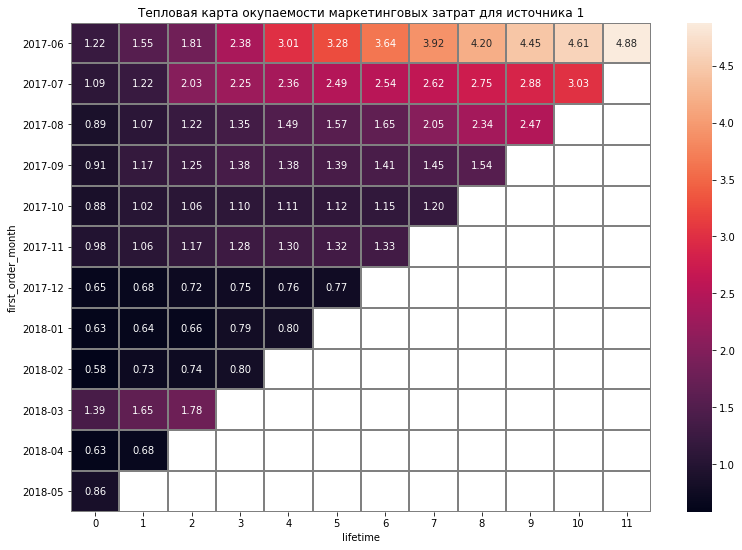

Средний ROMI для источника 1:


,0,source
lifetime,,
0,0.892500,1
1,1.042727,1
2,1.244000,1
3,1.342222,1
4,1.526250,1
5,1.705714,1
6,1.953333,1
7,2.248000,1
8,2.707500,1


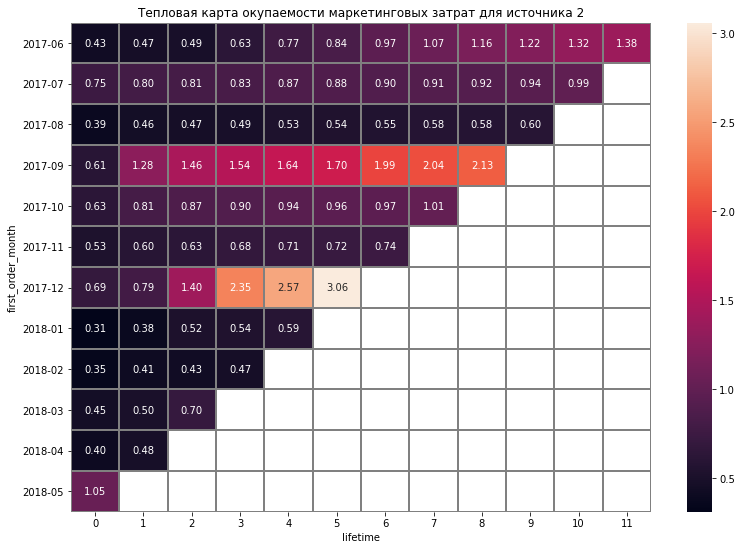

Средний ROMI для источника 2:


,0,source
lifetime,,
0,0.549167,2
1,0.634545,2
2,0.778000,2
3,0.936667,2
4,1.077500,2
5,1.242857,2
6,1.020000,2
7,1.122000,2
8,1.197500,2


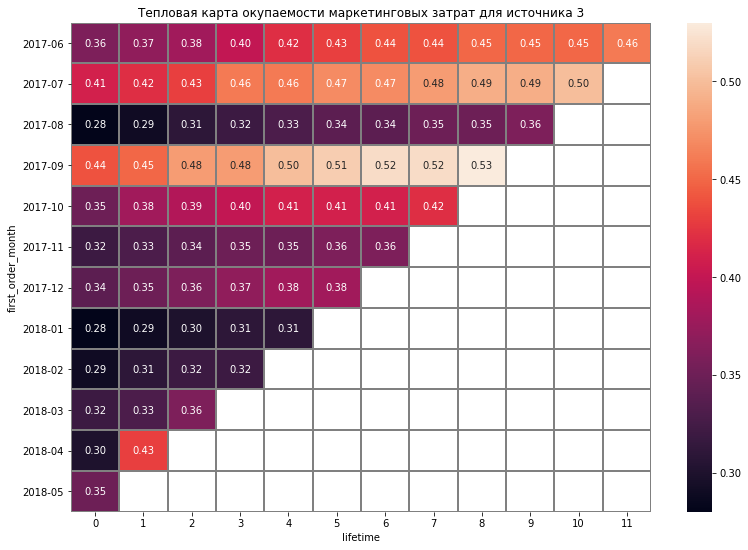

Средний ROMI для источника 3:


,0,source
lifetime,,
0,0.336667,3
1,0.359091,3
2,0.367000,3
3,0.378889,3
4,0.395000,3
5,0.414286,3
6,0.423333,3
7,0.442000,3
8,0.455000,3


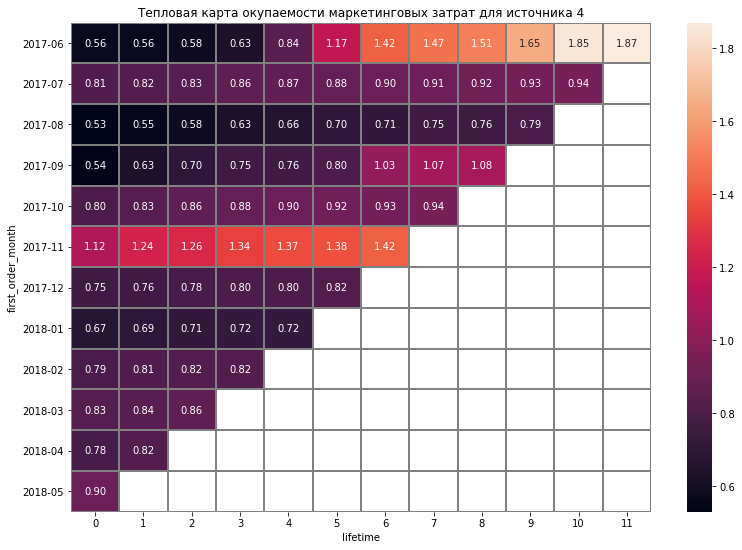

Средний ROMI для источника 4:


,0,source
lifetime,,
0,0.756667,4
1,0.777273,4
2,0.798000,4
3,0.825556,4
4,0.865000,4
5,0.952857,4
6,1.068333,4
7,1.028000,4
8,1.067500,4


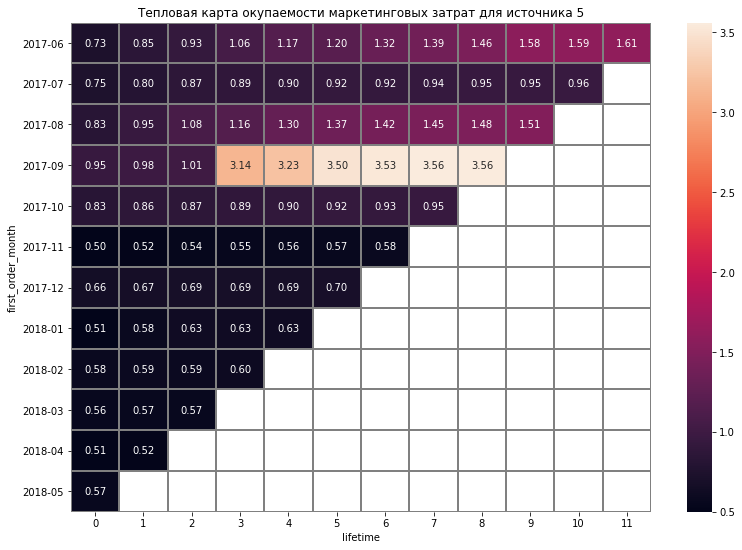

Средний ROMI для источника 5:


,0,source
lifetime,,
0,0.665000,5
1,0.717273,5
2,0.778000,5
3,1.067778,5
4,1.172500,5
5,1.311429,5
6,1.450000,5
7,1.658000,5
8,1.862500,5


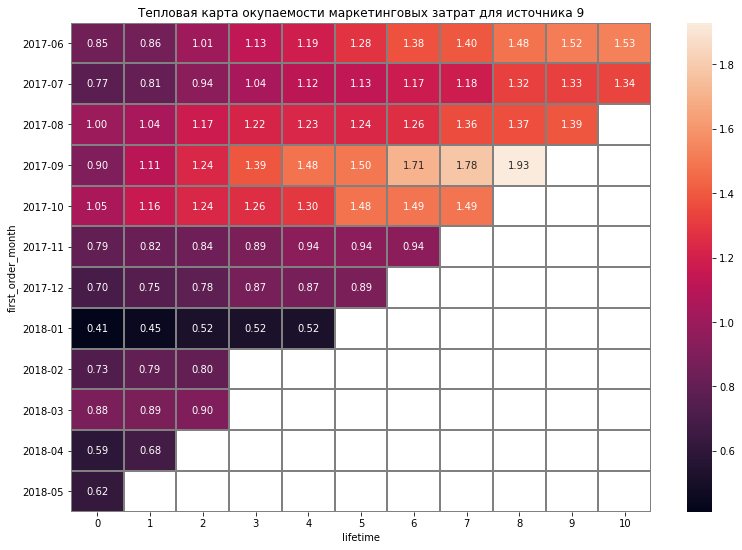

Средний ROMI для источника 9:


,0,source
lifetime,,
0,0.774167,9
1,0.850909,9
2,0.944000,9
3,1.040000,9
4,1.081250,9
5,1.208571,9
6,1.325000,9
7,1.442000,9
8,1.525000,9


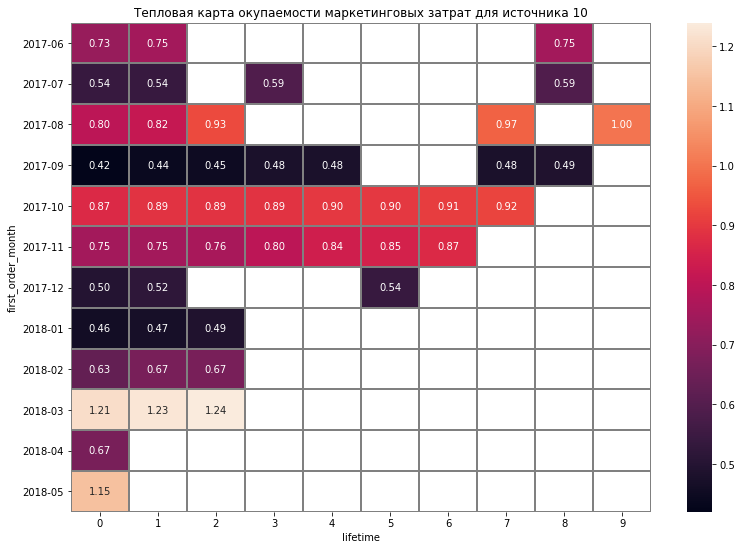

Средний ROMI для источника 10:


,0,source
lifetime,,
0,0.727500,10
1,0.708000,10
2,0.775714,10
3,0.690000,10
4,0.740000,10
5,0.763333,10
6,0.890000,10
7,0.790000,10
8,0.610000,10


In [50]:
#Группируем визиты по источнику и месяцу
users_by_source_and_month = visits.sort_values(by = ['uid', 'start_ts']).groupby('uid').agg({'source_id':'first', 'month':'first'}).reset_index()
#Группируем затраты по источнику и месяцу
costs_by_source_and_month = costs.groupby(['source_id', 'cost_month']).agg({'costs':'sum'}).reset_index()
sources = ['1','2','3','4','5','9','10']
#В цикле проходим по всем источникам рекламы
for i in sources:
  #Отбираем данные по визитам только для выбранного источника
  users_by_source = users_by_source_and_month.query('source_id == @i')
  #Отбираем из данных по визитам данные по покупкам
  orders_by_source = orders.query('uid in @users_by_source.uid')
  #Отбираем затраты по источнику
  costs_by_source = costs_by_source_and_month.query('source_id == @i')

  #Расчет САС по источникам
  #Группируем количество покупателей по когортам и добавляем в таблицу затрат
  n_buyers_by_source = orders_by_source.groupby('first_order_month').agg({'uid':'nunique'}).reset_index()
  n_buyers_by_source.columns = ['first_order_month', 'n_buyers']
  costs_by_source = costs_by_source.merge(n_buyers_by_source, left_on = 'cost_month', right_on = 'first_order_month')
  #САС = затраты на привлечение / количество покупателей
  costs_by_source['cac'] = costs_by_source['costs'] / costs_by_source['n_buyers']
  #Выделяем нужные столбцы в отдельный дф для удобства
  cac_by_source = costs_by_source[['cost_month','cac']]

  #Расчет LTV по источникам (код идентичен общему расчету LTV)
  cohort_revenue_by_source = orders_by_source.groupby(['first_order_month', 'order_month']).agg({'revenue':'sum'}).reset_index()
  cohort_revenue_by_source = cohort_revenue_by_source.merge(n_buyers_by_source, on = 'first_order_month')
  cohort_revenue_by_source['lifetime'] = ((cohort_revenue_by_source['order_month'] - cohort_revenue_by_source['first_order_month']) / np.timedelta64(1,'M')).round().astype('int')
  marg = 1
  cohort_revenue_by_source['gross_profit'] = cohort_revenue_by_source['revenue'] * marg
  cohort_revenue_by_source['ltv'] = cohort_revenue_by_source['gross_profit'] / cohort_revenue_by_source['n_buyers']

  #Расчет ROMI по источникам
  cohort_revenue_by_source = cohort_revenue_by_source.merge(cac_by_source, left_on = 'order_month', right_on = 'cost_month')
  cohort_revenue_by_source['romi'] = cohort_revenue_by_source['ltv'] / cohort_revenue_by_source['cac']
  cohort_revenue_by_source['first_order_month'] = cohort_revenue_by_source['first_order_month'].dt.strftime('%Y-%m')
  romi_pivot_by_source = cohort_revenue_by_source.pivot_table(index = 'first_order_month', columns = 'lifetime', values = 'romi', aggfunc = 'mean')
  cum_romi_by_source = romi_pivot_by_source.cumsum(axis=1).round(2)
  plt.figure(figsize=(13,9))
  plt.title('Тепловая карта окупаемости маркетинговых затрат для источника {}'.format(i))
  sns.heatmap(data = cum_romi_by_source, annot = True, fmt = '.2f', linewidth = 1, linecolor = 'grey') 
  plt.show()
  print('Средний ROMI для источника {}:'.format(i))
  romi_mean_by_source = cum_romi_by_source.mean(axis=0).to_frame()
  romi_mean_by_source['source'] = i
  display(romi_mean_by_source)

ROMI-анализ показал:
*   Быстрее всего окупаются затраты на привлечение клиентов по первому источнику. Однако количество пришедших из него пользователей пока мало. Это зона роста.
*   На пятый месяц окупаются затраты на привлечение из второго источника. Можно увеличивать затраты на привлечение в этом направлении для увеличения количества пользователей.
*   Третий источник убыточен. Стоит оптимизировать затраты и переориентироваться на привлечение клиентов из самого потенциально прибыльного источника №4. Затраты окупятся на седьмой месяц.

## Выводы (модель поведения среднего пользователя)<a id="conclusions"></a>

Проведённый анализ выявил модель поведения среднего пользователя:
*   Пользование сервисом "Яндекс-Афиша" имеет четко выраженную цикличность и сезонность. **Визиты и продажи падают в выходные и с наступлением тёплого времени года**
*   Пик востребованности сервиса - ноябрь 2017 года (нужно проверить данные за 24-11-2017 на корректность)
*   **В среднем пользователь заходит на сервис один раз в день**. Это может говорить об удобстве пользования Афишей
*   75% посещений не длиннее получаса. За это время большая часть пользователей подбирает себе вариант для досуга. Но **чаще всего сеанс длится минуту и менее**
*   Первую покупку пользователь обычно совершает в пределах двух дней с момента первого визита
*   **Повторно на сайт возвращается только порядка 6,5% пользователей**. Примерно вдвое меньше пользователей делают повторные покупки
*   **В среднем за полгода пользователь сервиса делает 1 покупку**. К концу года каждый покупатель первой когорты в среднем делает заказ дважды
*  Средний чек на пользователя колеблется не широко - от 4.06 до 5.86 у.е. Максимальный доход на пользователя был достигнут в декабре. В том числе это связано с большим количеством очень дорогих заказов одного пользователя в этот период (нужно проверить корректность этих данных)


## Рекомендации <a id="recommend"></a>

**Общие затраты на маркетинг превышают доходы**. Для того, чтобы выяснить причины, исследовали ROMI по источникам трафика. По итогам можно дать рекомендации:
*   Маркетинговые расходы по третьему источнику стоит оптимизировать. Он убыточен, хоть и приносит много клиентов.
*   **Точки роста - первый и второй источники**, причем первый окупается практически сразу же, т.к. не требует больших вложений.
*   **Самый перспективный - источник №4**. Он приносит много потенциальных клиентов при средних маркетинговых расходах.